These tutorials are very brief and aim to get you started. They are not replacements for official documentation or for understanding the finer points of deep learning methods.

Goal: The main aim of this notebook is to show how neural networks learn vector representations of input data

We will be using a small, standard dataset of handwritten digits called MNIST. This notebook also introduces two new PyTorch concepts - Datasets and DataLoaders

### Imports

In [1]:
import torch #pytorch
import torch.nn as nn #nn submodule with convenience functions for defining neural nets
import torch.optim as optim #optim submodule for gradient descent (don't worry about this for now)
from torch.utils.data import Dataset, DataLoader #new imports
import torch.nn.functional as F

import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import PILToTensor, Normalize, Compose

import numpy as np 
import matplotlib.pylab as plt
import inspect
%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else "cpu"

### MNIST dataset

In [3]:
#change download=True if you don't have the dataset locally
train_ds = MNIST(root='../', train=True, download=False)
test_ds = MNIST(root='../', train=False, download=False)

In [4]:
#this is a class inherited from torch.utils.data.Dataset which implements two interfaces:
# len(ds) i.e. a function __len__ that returns the number of records in the dataset
# ds[i] i.e. a function __getitem__(int) that returns the ith record
print(type(train_ds))

inspect.getmro(MNIST) #print class hierarchy

<class 'torchvision.datasets.mnist.MNIST'>


(torchvision.datasets.mnist.MNIST,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [5]:
print(len(train_ds))

60000


In [6]:
print(type(train_ds[10]))
print(len(train_ds[10]))

<class 'tuple'>
2


In [7]:
train_ds[10][0] #input - 28 x 28 grayscale image

In [8]:
train_ds[10][1] #output - integer label

3

Another useful abstraction is that of a DataLoader. Training neural networks is an iterative process. One initializes the network with some weights and repeats the following pattern in a loop:

* "Look" at the data where "Look" = make predictions -> compared to labels using a loss function -> backpropagate the loss to compute derivatives

* "Adjust" the weights where "Adjust" = apply additive correction to weights using some form of gradient descent

Each execution of this loop is called an epoch. The number of epochs is technically as much as is required for the neural network to "learn" the task and generalize i.e. be able to predict on the non-training set. Less epochs will result in a network that has lower performance (accuracy etc.) and more epochs will lead to overfitting (memorizing the training set and not predicting well on the test set).

The most straightforward implementation of the "Look" part would make predictions on the full dataset. In practice, this is not done. Rather, the dataset is broken up into disjoint (non-overlapping) batches of a fixed size (32 in the cell below). Of course, the last batch will, in general, not be of the same size. The "Look"-"Adjust" loop is now carried out on one batch at a time. One epoch is still defined to be one pass through the entire dataset but instead of doing the pass in one big computation, it's broken up into many smaller computations over each batch. There are two main advantages to this:

(The following is just a mental dump so we should probably go over this more carefully in a call)

* Since a batch is much smaller than the full dataset, the memory requirements are much lower. GPUs generally are limited in memory (compared to main memory) and models can be very large themselves (and sit on the GPU). So, paying the cost of transferring batches from main memory -> GPU memory is often a good tradeoff to enable training larger models. To be explicit, instead of transferring the full dataset into the GPU memory, we now only transfer the small batches. The tradeoff is that the full dataset would need to be transferred once but the batches need to be transferred once per epoch to the GPU (there are optimizations though).

* There's an algorithmic advantage to batches too. From the model's perspective, the data is only useful for computing the gradient (derivative of the scalar loss with respect to each weight). Each example/record in the data is used to compute an estimate of the gradient and these estimates are averaged over the full dataset. Moving from full dataset -> batches is equivalent to saying that instead of computing the gradient from the full dataset, we are now computing an estimate of the gradient from a much smaller number of examples (just like instead of computing the average height of a population, we sample a subset of people and get a noisier estimate). Getting noisier estimates of the gradient is actually useful to escape from local minima during training.



In [9]:
#don't want outputs to be images. want tensors. the argument to transform is applied to every input

tfm = Compose([PILToTensor()])

train_ds = MNIST(root='../', train=True, download=False, transform = tfm)
test_ds = MNIST(root='../', train=False, download=False, transform = tfm)

In [10]:
#these dataloaders will break up each dataset into chunks of 32 images (and their labels)
train_dl = DataLoader(train_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)

In [11]:
#look at one chunk
X, y = next(iter(train_dl)) #get the next item from an iterator

In [12]:
X.shape #32 images with 1 channel (grayscale) and height=width=28

torch.Size([32, 1, 28, 28])

In [13]:
y.shape #32 labels

torch.Size([32])

TypeError: Invalid shape (3, 122, 242) for image data

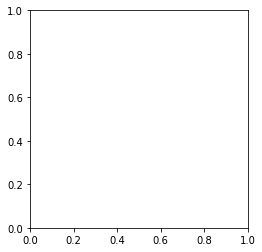

In [14]:
plt.imshow(torchvision.utils.make_grid(X))

### Defining the neural network

In [15]:
#simple feedforward neural net (multilayer perceptron)
net = nn.Sequential(nn.Flatten(start_dim=1, end_dim=3),
                    nn.Linear(28*28, 128),
                    nn.ReLU(),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, 10)) #10 output classes

net = net.to(device)

criterion = nn.CrossEntropyLoss() #multi-class classification loss (using logits)
optimizer = optim.AdamW(net.parameters(), lr=1e-3)

In [16]:
X = X.to(device)
y = y.to(device)

In [17]:
criterion(net(X/255.), y)

tensor(2.3063, device='cuda:0', grad_fn=<NllLossBackward0>)

In [18]:
y

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8], device='cuda:0')

In [19]:
def train(net, n_epochs, train_dl, test_dl, print_freq=100, device='cpu'): #n_epochs = N    
    net.train() #don't worry about this for now
    
    for n in range(n_epochs):
        #unlike tutorial 1, we now operate on each batch
        
        for i, (X,y) in enumerate(train_dl):            
            
            X = X.to(device)
            y = y.to(device)
            
            pred = net(X.float()/255.) #make predictions on a *batch*
        
            loss = criterion(pred, y) #compute loss i.e. compare predictions to labels
        
            optimizer.zero_grad() #technical point: clear gradient buffers at each epoch
            loss.backward() #compute derivatives of the loss with respect to the net's parameters
            optimizer.step() #change parameters by doing gradient descent
                
        if n % print_freq == 0:
            train_acc = validate(net, train_dl)
            test_acc = validate(net, test_dl)
            print(f'Training accuracy = {train_acc:.3f} Test accuracy = {test_acc:.3f}')
            net.train()
            
    return net

def validate(net, test_dl):
    net.eval() #don't worry about this for now
    n_correct = 0
    n_total = 0
    
    with torch.no_grad(): #don't store gradients since we are not training here
        for i, (X,y) in enumerate(test_dl):
            X = X.to(device)
            y = y.to(device)
            
            pred = net(X.float()/255.) #make predictions on a *batch*
            
            #don't want just probabilities. pick class with maximum probability
            pred = torch.argmax(pred, dim=1)
            
            n_correct += (pred==y).sum()
            n_total += pred.shape[0]
            
    return n_correct/n_total

In [20]:
net = train(net, 20, train_dl, test_dl, print_freq=10, device=device)

Training accuracy = 0.947 Test accuracy = 0.945
Training accuracy = 0.992 Test accuracy = 0.977


This network has pretty high test accuracy, albeit on a very simple dataset

### Vector Representations

Once the network is trained and is accurate on the test set, we can thinking of it as a machine to map input data to a sequence of vectors. The finally vector is the prediction (the log probabilities of belonging to each class).

In [21]:
net

Sequential(
  (0): Flatten(start_dim=1, end_dim=3)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
)

We can refer to each layer by indexing: net[0], net[1] etc.

In [22]:
net[3]

Linear(in_features=128, out_features=64, bias=True)

In [23]:
net[4]

ReLU()

To get the vector representations, called activations, we can register a function or a hook.

In [24]:
activations = {'layer1': [], 'layer3': []}
#activations = {}

def get_hook(name):
    def hook(model, input, output):
        #activations[name] = output.detach() #overwrite any existing tensors in dictionary
        activations[name].append(output.detach())
        
    return hook
        
a1 = net[1].register_forward_hook(get_hook('layer1')) #activations after layer 1
a2 = net[3].register_forward_hook(get_hook('layer3')) #activations after layer 3

In [25]:
activations

{'layer1': [], 'layer3': []}

In [26]:
def get_activations(net, dl, device):
    with torch.no_grad():
        for i, (X,y) in enumerate(dl):
            X = X.to(device)
            
            _ = net(X/255.) #activations get stored

In [27]:
get_activations(net, test_dl, device)

In [28]:
#remove hooks
a1.remove()
a2.remove()

In [29]:
len(activations['layer1']) * 32

10016

In [30]:
torch.cat(activations['layer3']).shape

torch.Size([10000, 64])

In [39]:
act = torch.cat(activations['layer3']).cpu()

In [40]:
sim = F.cosine_similarity(act[:,None,:], act[None,:,:], dim=-1)

In [41]:
sim.shape

torch.Size([10000, 10000])

label = 5


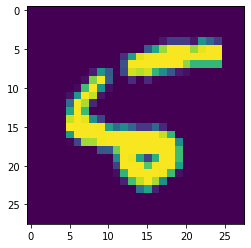

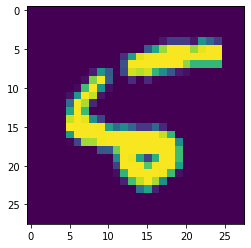

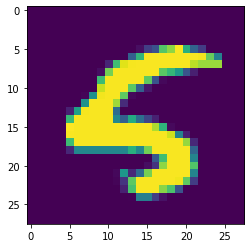

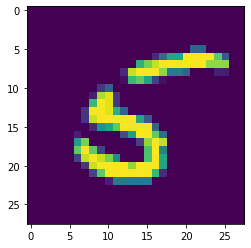

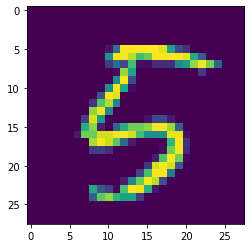

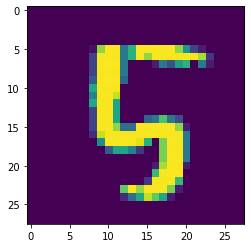

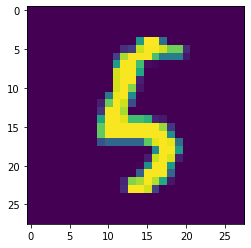

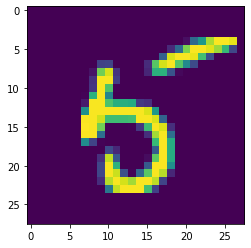

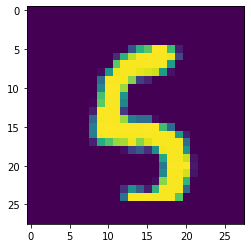

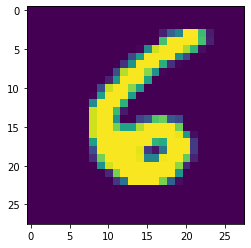

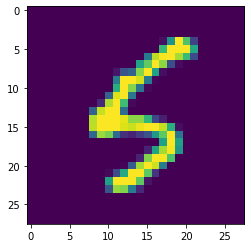

In [60]:
idx = 8 #CHANGE THIS
plt.imshow(test_ds[idx][0].squeeze(0).numpy())
print(f'label = {test_ds[idx][1]}')

sorted_matches = sim[idx,:].argsort(descending=True)

for match_idx in sorted_matches[0:10]: #plot first 10 matches
    plt.figure()
    plt.imshow(test_ds[match_idx][0].squeeze(0).numpy())

In [57]:
sorted_matches

tensor([   5, 6254, 4267,  ..., 6877,  271, 2479])